**Mount Google Drive To Retrieve Data From Cloud Storage**

In [2]:
# Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import Dependencies**

In [3]:
import re
import csv
import nltk
import zipfile
import numpy as np
import pandas as pd
import wordcloud
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

**Load and Display Cleaned Data**

In [5]:
# Load raw pre-cleaned data
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'
data = pd.read_csv(SAVE_PATH + 'data/Cleaned_Negation_IMDB_Dataset.csv')
data.review = data.review.astype(str)

print(data.head)
print("\n", data.shape)

<bound method NDFrame.head of                                                   review sentiment
0      one reviewers mentioned watching oz episode yo...  positive
1      wonderful little production filming technique ...  positive
2      thought wonderful way spend time hot summer we...  positive
3      basically theres family little boy jake thinks...  negative
4      petter matteis love time money visually stunni...  positive
...                                                  ...       ...
49995  thought movie right good job wasnt creative or...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  catholic taught parochial elementary schools n...  negative
49998  im going disagree previous comment side maltin...  negative
49999  no one expects star trek movies high art fans ...  negative

[50000 rows x 2 columns]>

 (50000, 2)


**Separate Review Text and Labels**

In [6]:
x_vals = data['review'].values
y_vals = data['sentiment'].values
print("Review Text:\n------------\n", x_vals)
print("\nSentiment:\n----------\n", y_vals)

Review Text:
------------
 ['one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy not high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards wholl sold nickel inmates wholl 

**Vectorize Sentiment Labels**

In [8]:
# Convert positive labels to 1, negative to 0
y_vals[y_vals == 'positive'] = 1
y_vals[y_vals == 'negative'] = 0
y_vals.resize((y_vals.shape[0], 1))
y_vals = np.asarray(y_vals).astype(np.int)

print(y_vals)
print("\n", y_vals.shape)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]

 (50000, 1)


**Partition Data**

In [10]:
from sklearn.model_selection import train_test_split

# Randomize and split entire dataset into 80% train, 20% validation
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=.2, random_state=5)
print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)

Training: (40000,) (40000, 1)
Testing: (10000,) (10000, 1)


In [18]:
x_test.resize(x_test.shape[0], 1)
print(x_test.shape)

(10000, 1)


**Load and Test LSTM Model**

In [14]:
model = load_model(SAVE_PATH + 'Stacked_LSTM_UNSTEMMED_Negated_Vocab3000')
model.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 45s 32ms/step - loss: 0.2808 - accuracy: 0.8798


[0.280788779258728, 0.879800021648407]

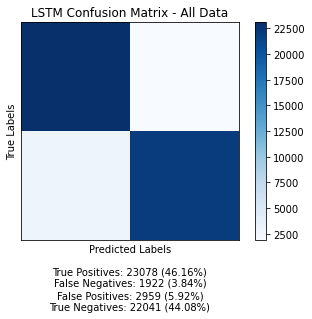

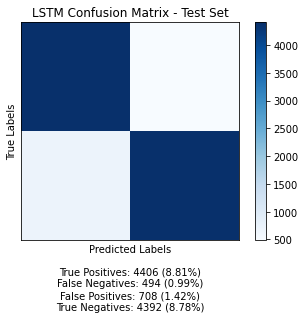

In [19]:
def get_caption(cm):
  return "\n\nTrue Positives: {} ({}%)\nFalse Negatives: {} ({}%)\nFalse Positives: {} ({}%)\nTrue Negatives: {} ({}%)".format(
    str(cm[0][0]), str(round((cm[0][0]/len(x_vals))*100, 2)),
    str(cm[0][1]), str(round((cm[0][1]/len(x_vals))*100, 2)),
    str(cm[1][0]), str(round((cm[1][0]/len(x_vals))*100, 2)),
    str(cm[1][1]), str(round((cm[1][1]/len(x_vals))*100, 2))
  )
  
# Generate predictions on full dataset
y_preds = model.predict(x_vals)
y_preds = np.where(y_preds > 0.5, 1, 0)
cm = confusion_matrix(y_vals, y_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('LSTM Confusion Matrix - All Data')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_alldata.png', bbox_inches='tight')
plt.show()


# Generate predictions on testing set
y_test_preds = model.predict(x_test)
y_test_preds = np.where(y_test_preds > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_test_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('LSTM Confusion Matrix - Test Set')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_testdata.png', bbox_inches='tight')
plt.show()

**LSTM Generate Precision, Recall, F1-Score**

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_preds, target_names=['Negative Sentiment', 'Positive Sentiment']))

                    precision    recall  f1-score   support

Negative Sentiment       0.86      0.90      0.88      4900
Positive Sentiment       0.90      0.86      0.88      5100

          accuracy                           0.88     10000
         macro avg       0.88      0.88      0.88     10000
      weighted avg       0.88      0.88      0.88     10000



**LSTM Misclassification Distribution**

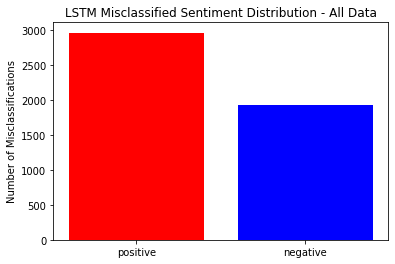

In [42]:
misclass_data = data.loc[y_preds != y_vals]
misclass_pos = misclass_data[misclass_data.sentiment == 1]
misclass_neg = misclass_data[misclass_data.sentiment == 0]

# Plot misclassified distribution
plt.bar(x=['positive', 'negative'], height=[misclass_pos.shape[0], misclass_neg.shape[0]], color=['red', 'blue'])
plt.title('LSTM Misclassified Sentiment Distribution - All Data')
plt.ylabel('Number of Misclassifications')
plt.savefig(SAVE_PATH + 'figures/LSTM_misclassification_distr_test.png')
plt.show()

**LSTM Highest Frequency Words Among Misclassifications**

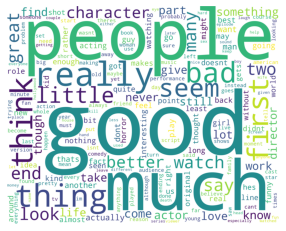

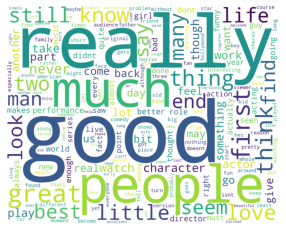

In [43]:
# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
misclass_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_pos['review'].values))
misclass_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_neg['review'].values))

# Display wordcloud images
plt.imshow(misclass_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(misclass_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
misclass_pos_wordcloud.to_file(SAVE_PATH + 'figures/misclass_pos_cloud.png')
misclass_neg_wordcloud.to_file(SAVE_PATH + 'figures/misclass_neg_cloud.png')

**LSTM Highest Frequency Words Among Correct Classifications**

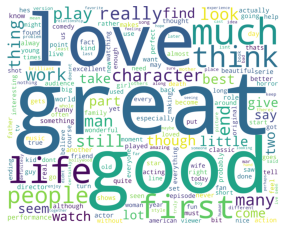

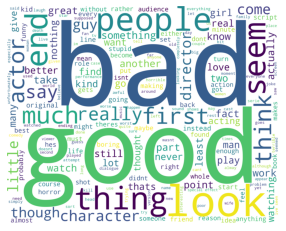

In [46]:
# Separate correctly classified data 
correct_data = data.loc[y_preds == y_vals]
correct_pos = correct_data[correct_data.sentiment == 1]
correct_neg = correct_data[correct_data.sentiment == 0]

# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
correct_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_pos['review'].values))
correct_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_neg['review'].values))

# Display wordcloud images
plt.imshow(correct_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(correct_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
correct_pos_wordcloud.to_file(SAVE_PATH + 'figures/correct_pos_cloud.png')
correct_neg_wordcloud.to_file(SAVE_PATH + 'figures/correct_neg_cloud.png')

**Load and Test NB Model**

In [16]:
!pip install pickle5

     |████████████████████████████████| 133kB 27.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219263 sha256=b136e4a497994bab8d70569360cd467ffd2ce05109d4a93bbf382afb2aa77665
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [47]:
# Load NB model, vectorizer, and transformer
import pickle5 as pickle
nb_model = pickle.load(open(SAVE_PATH + 'NB/NB_Multinomial.sav', 'rb'))
nb_vectorizer = pickle.load(open(SAVE_PATH + 'NB/count_vectorizer.pickle', 'rb'))
nb_transformer = pickle.load(open(SAVE_PATH + 'NB/TFID_Transformer.pickle', 'rb'))

# Load stemmed data NB was trained on
data = pd.read_csv(SAVE_PATH + 'data/Cleaned_Negation_Stemmed_IMDB_Dataset.csv')
x_vals = data['review']
y_vals = data['sentiment']
x_vals = nb_vectorizer.transform(x_vals)
x_vals = nb_transformer.transform(x_vals)

# Randomize and split entire dataset into 80% train, 20% testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=.2, random_state=5)
print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Training: (40000, 552822) (40000,)
Testing: (10000, 552822) (10000,)


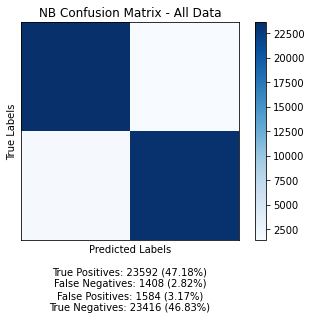

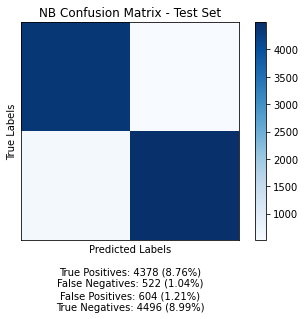

In [48]:
def get_caption(cm):
  return "\n\nTrue Positives: {} ({}%)\nFalse Negatives: {} ({}%)\nFalse Positives: {} ({}%)\nTrue Negatives: {} ({}%)".format(
    str(cm[0][0]), str(round((cm[0][0]/x_vals.shape[0])*100, 2)),
    str(cm[0][1]), str(round((cm[0][1]/x_vals.shape[0])*100, 2)),
    str(cm[1][0]), str(round((cm[1][0]/x_vals.shape[0])*100, 2)),
    str(cm[1][1]), str(round((cm[1][1]/x_vals.shape[0])*100, 2))
  )

# Generate predictions on full dataset
y_preds = nb_model.predict(x_vals)
cm = confusion_matrix(y_vals, y_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('NB Confusion Matrix - All Data')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/nb_confusion_matrix_alldata.png', bbox_inches='tight')
plt.show()


# Generate predictions on testing set
y_test_preds = nb_model.predict(x_test)
cm = confusion_matrix(y_test, y_test_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('NB Confusion Matrix - Test Set')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/nb_confusion_matrix_testdata.png', bbox_inches='tight')
plt.show()

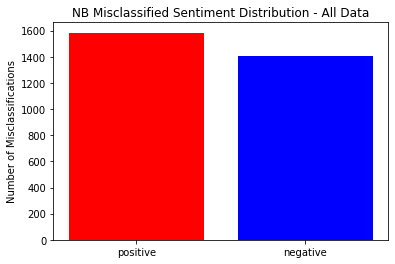

In [51]:
# Plot misclassified distribution
nb_misclass_labels = y_preds[y_preds != y_vals]
nb_misclass_counts = np.bincount(nb_misclass_labels == 'positive')
plt.bar(x=['positive', 'negative'], height=[nb_misclass_counts[0], nb_misclass_counts[1]], color=['red', 'blue'])
plt.title('NB Misclassified Sentiment Distribution - All Data')
plt.ylabel('Number of Misclassifications')
plt.savefig(SAVE_PATH + 'figures/nb_misclassification_distr.png')
plt.show()

In [52]:
data_total = x_test.shape[0]
nb_num_incorrect = nb_misclass_test_counts[0] + nb_misclass_test_counts[1]
nb_num_correct = data_total - nb_num_incorrect
nb_pct_correct = round(nb_num_correct / data_total, 4)
print('NB Evaluation - Test Data:')
print('{}/{}\t- accuracy: {}'.format(nb_num_correct, data_total, nb_pct_correct))

NB Evaluation - Test Data:
8874/10000	- accuracy: 0.8874


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_preds, target_names=['Negative Sentiment', 'Positive Sentiment']))

                    precision    recall  f1-score   support

Negative Sentiment       0.88      0.89      0.89      4900
Positive Sentiment       0.90      0.88      0.89      5100

          accuracy                           0.89     10000
         macro avg       0.89      0.89      0.89     10000
      weighted avg       0.89      0.89      0.89     10000



**Excerpts of Misclassified Text**

In [ ]:
import textwrap
import random

# Separate data
misclass_pos_text = misclass_pos['review'].values
misclass_neg_text = misclass_neg['review'].values

# Display excerpts of texts in dataset that were misclassified
# Typically include both positive and negative remarks in review
def underline(text): return text + '\n' + ('-' * len(text))

print(underline("Postive Labeled Reviews Predicted Negative:"), "\n")
for i in [90, 164]:
  print(textwrap.fill(misclass_pos_text[i], 75), "\n")

print(underline("Negative Labeled Reviews Predicted Positive:"), "\n")
for i in [66, 551]:
  print(textwrap.fill(misclass_neg_text[i], 75), "\n")

Postive Labeled Reviews Predicted Negative:
------------------------------------------- 

worst movie ive ever seen yet also best movie sci fi original movies
supposed bad thats makes fun line like dinosaur meat well done probably
best quote ever also plot sounds like something pot induced dream imagine
writers waking long night getting high playing dance dance revolution
putting ideas together space marines got alien planet infested dinosaurs
medieval houses protect science team studying planet best idea ever fact
fits complete sci fi original movie checklist guns dinosaurs medieval times
space travel terrible actingso go watch movie dont buy 

without kirsten miller project neednt completed however awe inspiring
beauty talent miss miller would definitely recommend looked actors playing
strong performance wagners dismal attempt honor film bit disappointing
scenes didnt detract entertained mostly criticisms writing plot line group
talent assembled heroic job salvaging disaster charisma